In [87]:
import pandas as pd
import urllib
from SPARQLWrapper import SPARQLWrapper, JSON
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import seaborn
import numpy as np
import itertools
import MeCab
import gensim
from janome.tokenizer import Tokenizer
import json
from pandas import plotting
from sklearn.decomposition import FactorAnalysis as FA

In [88]:
def stats():
    
    #API URL
    API_URL_JSON = r"http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData?"
    API_URL_CSV = r"http://api.e-stat.go.jp/rest/3.0/app/getSimpleStatsData?"
    #アプロケーションID
    APP_ID = "f16b57e949d93c21f7cba33ef607c6dfa49c813b"

    #統計表ID
    statsDataId = "0003005922" #物価
    statsDataId = "0001883407" #耕地面積

    keys = {
            "appId"            : APP_ID,
            "lang"             : "J" ,
            "statsDataId"      : statsDataId ,
            "metaGetFlg"       : "Y" ,
            "cntGetFlg"        : "N",
            "sectionHeaderFlg" : "1"
        }

    query_param = urllib.parse.urlencode(keys)
    res = pd.read_json(urllib.request.urlopen(API_URL_JSON + query_param).read(), orient='records')

    df = pd.DataFrame(res['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE'])
    df2 = df.copy()
    print(df.head())
    
    class_df = pd.DataFrame(res['GET_STATS_DATA']['STATISTICAL_DATA']['CLASS_INF']['CLASS_OBJ'])
    print(class_df['CLASS'])
    

    #これで良くねindex=年への成形と列名の置換
    df2['$'] = pd.to_numeric(df2["$"], errors="coerce")
    df2 = df2.pivot_table('$', index='@cat01', columns='@cat02')
    
    
    #欠損値の置換
    df3 = df2.copy()
    for column_name, item in df2.iteritems():
        df3.loc[:, column_name] = pd.to_numeric(item, errors="coerce")
    
    #相関係数
    df5_corr = df3.corr()
    
    #jsonに書き出し
    path = './corrdata.json'
    df5_corr.to_json(path, force_ascii=False)
    return df5_corr

#stats()

In [16]:
res_list = res['GET_STATS_DATA']['STATISTICAL_DATA']['CLASS_INF']['CLASS_OBJ']

#属性置換
if '@cat01' in df.columns:
    cat1_json = [x for x in res_list if x['@id'] == 'cat01'][0]['CLASS']
    cat1_dict = {}
    for item in cat1_json:
        cat1_dict[item['@code']] = item['@name']
    df2.replace({'@cat01': cat1_dict}, inplace=True)
    

NameError: name 'res' is not defined

In [89]:

url = "http://data.e-stat.go.jp/lod/sparql/alldata/query"
sparql = SPARQLWrapper(url)
sparql.setReturnFormat(JSON)


prefix = """
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix xsd: <http://www.w3.org/2001/XMLSchema#>
prefix sdmx-dimension: <http://purl.org/linked-data/sdmx/2009/dimension#>
prefix sdmx-measure: <http://purl.org/linked-data/sdmx/2009/measure#>
prefix cd-dimension: <http://data.e-stat.go.jp/lod/ontology/crossDomain/dimension/>

PREFIX g00200502-dimension:<http://data.e-stat.go.jp/lod/ontology/g00200502/dimension/>
"""


query = """
select ?indicatorLabel ?observation ?year
where {
      ?s sdmx-measure:obsValue ?observation ;
         sdmx-dimension:refArea / rdfs:label 'さいたま市'@ja ;
         g00200502-dimension:indicator / rdfs:label ?indicatorLabel ;
         g00200502-dimension:indicator ?indicator ;
         cd-dimension:timePeriod ?year .
FILTER(LANG(?indicatorLabel)='ja')
}
ORDER BY ASC(?indicator)
"""

sparql.setQuery(prefix + query)
results = sparql.query().convert()

sql_df = pd.json_normalize(results["results"]["bindings"])
sql_df = sql_df[['year.value','indicatorLabel.value','observation.value']]
sql_df

,year.value,indicatorLabel.value,observation.value
0,2005,人口総数,1176314
1,2015,人口総数,1263979
2,2010,人口総数,1222434
3,2010,人口総数（男）,611236
4,2005,人口総数（男）,590972
...,...,...,...
4098,2004,刑法犯認知件数,31231
4099,2003,刑法犯認知件数,28676
4100,2002,刑法犯認知件数,29155
4101,2006,刑法犯認知件数,24273


In [90]:
sql_df = sql_df.astype({'observation.value': float})
sql_df2 = sql_df.pivot_table('observation.value', index='year.value', columns='indicatorLabel.value')
sql_df2 = sql_df2.reset_index()
sql_df2 = sql_df2.astype({'year.value': int})

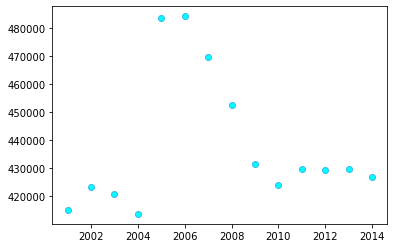

In [6]:
sql_df3 = sql_df2.dropna(how='any', subset=['ごみ総排出量'])
x = sql_df3['year.value']
y = sql_df3['ごみ総排出量']
 
# 散布図を描画
plt.scatter(x, y, c='#00FFFF', edgecolors="#37BAF2")

y= -129.547x + 698225.396
決定係数 R^2：  0.0005018757960649767


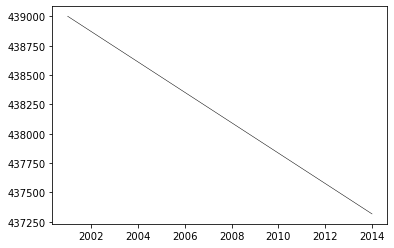

In [7]:
# 回帰分析　線形
mod = LinearRegression()
df_x = pd.DataFrame(x)
df_y = pd.DataFrame(y)
# 線形回帰モデル、予測値、R^2を評価
mod_lin = mod.fit(df_x, df_y)
y_lin_fit = mod_lin.predict(df_x)
r2_lin = mod.score(df_x, df_y)

plt.plot(df_x, y_lin_fit, color = '#000000', linewidth=0.5)

print('y= %.3fx + %.3f' % (mod.coef_ , mod.intercept_))
print('決定係数 R^2： ', mod.score(df_x, df_y))

In [91]:
mod = LinearRegression()
filled_df = sql_df2.copy()

for column_name, item in sql_df2.iteritems():
    if item.isnull().any():
        #回帰直線の導出
        temp_df3 = sql_df2.dropna(how='any', subset=[column_name])
        x = temp_df3['year.value']
        y = temp_df3[column_name]
        
        df_x = pd.DataFrame(x)
        df_y = pd.DataFrame(y)

        mod_lin = mod.fit(df_x, df_y)
        y_lin_fit = mod_lin.predict(df_x)
        #print(column_name)
        
        filled_df[column_name].fillna(mod.coef_[0][0] * sql_df2['year.value'] + mod.intercept_[0] , inplace=True)

In [102]:
#nodeの因子分析によるクラスタリング


#filled_df.describe()
# データを変換する計算式を生成
sc = StandardScaler()
sc.fit(filled_df)

# 実際にデータを変換
z = sc.transform(filled_df)

# 因子数を指定
n_components=3

# 因子分析の実行
fa = FA(n_components, max_iter=5000) # モデルを定義
fitted = fa.fit_transform(z) # fitとtransformを一括処理

#因子得点 print(fitted)

#因子付加量
Factor_loading_matrix = fa.components_.T
# データフレームに変換
load_df = pd.DataFrame(Factor_loading_matrix, columns=["第1因子", "第2因子", "第3因子"], index=[filled_df.columns])
#3つの因子にクラスタリング
classed_df = abs(load_df).T.idxmax()
classed_df

indicatorLabel.value
year.value              第1因子
ごみのリサイクル率               第1因子
ごみ処理量（直接資源化）            第1因子
ごみ処理量（総量）               第3因子
ごみ総排出量                  第3因子
                        ... 
７５歳以上人口（女）              第1因子
７５歳以上人口（男）              第1因子
８０歳以上人口                 第1因子
８０歳以上人口（女）              第1因子
８０歳以上人口（男）              第1因子
Length: 750, dtype: object

In [92]:
corr_sql_df2 = filled_df.corr() #レコードが小さい奴はNaNになる
corr_sql_df2 = corr_sql_df2.dropna(how='all').dropna(how='all', axis=1)
df = corr_sql_df2.copy()
#絶対値に変換
df = abs(df)

In [93]:
#列名が似ているもの同士の値は、面白くないからNaN

#わかち書き関数
def wakachi(text):
    
    t = Tokenizer()
    tokens = t.tokenize(text)
    docs=[]
    for token in tokens:
        docs.append(token.surface)
    return docs
 
#文書ベクトル化関数
def vecs_array(documents):
 
    docs = np.array(documents)
    vectorizer = TfidfVectorizer(analyzer=wakachi,binary=True,use_idf=False)
    vecs = vectorizer.fit_transform(docs)
    return vecs.toarray()
 
docs = df.columns

#類似度行列作成
cs_array = np.round(cosine_similarity(vecs_array(docs), vecs_array(docs)),3)
#類似度行列データフレームバージョン
rdf = pd.DataFrame(data=cs_array, columns=df.columns, index=df.columns)

#名前が似ているものはNaN
df = df[rdf < 0.5]

In [94]:
#相関が1と|0.9|以下のものはNaN
def irregular(x):
    if abs(x) <= 0.9 or abs(x) == 1:
        return np.nan
    else:
        return x
df = df.applymap(irregular)


#二分探索法：相関の中央値以下はNaN

def binali(x):
    
    if abs(x) <=  median:
        return np.nan
    else:
        return x

for i in range(3):
    median = df.median().median()
    df = df.applymap(binali)

In [95]:
#非対称要素の削除
#dfは時間かかるからコピー
df2 = df.copy()

column_list = []
for column in df.columns:
    if df2[column][:column].count() == 0: #その列の同じindexまで全てNaNの場合
        column_list.append(column) 
df2.drop(column_list, axis='columns', inplace=True)
df2.dropna(how="all", axis=0, inplace=True)

In [138]:
#JSONファイルへの書き出し

#相関の大きいやつだけ
dft = df.nlargest(30, df.columns).T
dft = dft.nlargest(30, dft.columns).T


temp_dict = {}

for index,row in dft.iterrows():
    temp_dict[index] = {**row.dropna().to_dict()}
    
with open('./test.json', 'w') as f:
    json.dump(temp_dict, f, ensure_ascii=False)
    
    
##############################################
label_id_dict = {}

i = 0

for index in dft.index:
    label_id_dict[index] = {'id': i, 'group': classed_df[index]}
    i= i + 1
    
for column in dft.columns:
    label_id_dict[column] = {'id': i, 'group': classed_df[column]}
    i= i + 1
    
print(label_id_dict)

with open('./label_id.json', 'w') as f:
    json.dump(label_id_dict, f,ensure_ascii=False)

{'労働力人口（男）': {'id': 0, 'group': '第1因子'}, '第３次産業事業所数': {'id': 1, 'group': '第1因子'}, '第３次産業就業者数': {'id': 2, 'group': '第1因子'}, '非労働力人口': {'id': 3, 'group': '第1因子'}, '従業者数（非農林漁業）': {'id': 4, 'group': '第1因子'}, '従業者数（地方公共団体）': {'id': 5, 'group': '第1因子'}, '従業者数（公務を除く）': {'id': 6, 'group': '第1因子'}, '流入人口（他県に常住している人口）': {'id': 7, 'group': '第1因子'}, '就業者': {'id': 8, 'group': '第1因子'}, '事業所数（民営）（金融業，保険業）（第12回改定産業分類）': {'id': 9, 'group': '第1因子'}, '事業所数（非農林漁業（公務を除く））': {'id': 10, 'group': '第1因子'}, '事業所数（公務を除く）': {'id': 11, 'group': '第1因子'}, '事業所数（不動産業，物品賃貸業）': {'id': 12, 'group': '第1因子'}, '流出人口（他県で従業・通学している人口)': {'id': 13, 'group': '第1因子'}, '事業所数（民営）（小売業）（第12回改定産業分類）': {'id': 14, 'group': '第1因子'}, '事業所数（民営）（卸売業，小売業）（第12回改定産業分類）': {'id': 15, 'group': '第1因子'}, '他県で従業している就業者数': {'id': 16, 'group': '第1因子'}, '事業所数（公務（他に分類されるものを除く））': {'id': 17, 'group': '第1因子'}, '事業所数（民営）（製造業）（第12回改定産業分類）': {'id': 18, 'group': '第1因子'}, '事業所数（民営）（不動産業，物品賃貸業）（第12回改定産業分類）': {'id': 19, 'group': '第1因子'}, '事業所数（卸売業，小売業）': {'id':

In [100]:
# average=0 に正規化
def to_std(df):
    average = df.mean().mean()
    sigma = pow(df - average, exp=2).sum().sum() / df.count().sum()
    std = np.sqrt(sigma)
    return (df - average) / std


In [25]:
#決定係数行列
Rdf = pd.DataFrame(columns=filled_df.columns, index=filled_df.columns)

mod = LinearRegression()

#重すぎる
for column in filled_df.columns:
    for column2 in filled_df.columns:
        
        df_x = pd.DataFrame(filled_df[column])
        df_y = pd.DataFrame(filled_df[column2])
        # 線形回帰モデル、予測値、R^2を評価
        mod.fit(df_x, df_y)
        r2_lin = mod.score(df_x, df_y)

        Rdf[column][column2] = mod.score(df_x, df_y)


KeyboardInterrupt: 

In [131]:
int_df = classed_df.replace(['第1因子','第2因子','第3因子'], ['0', '1', '2'])

indicatorLabel.value
year.value              0
ごみのリサイクル率               0
ごみ処理量（直接資源化）            0
ごみ処理量（総量）               2
ごみ総排出量                  2
                       ..
７５歳以上人口（女）              0
７５歳以上人口（男）              0
８０歳以上人口                 0
８０歳以上人口（女）              0
８０歳以上人口（男）              0
Length: 750, dtype: int64

In [132]:
classed_df

indicatorLabel.value
year.value              第1因子
ごみのリサイクル率               第1因子
ごみ処理量（直接資源化）            第1因子
ごみ処理量（総量）               第3因子
ごみ総排出量                  第3因子
                        ... 
７５歳以上人口（女）              第1因子
７５歳以上人口（男）              第1因子
８０歳以上人口                 第1因子
８０歳以上人口（女）              第1因子
８０歳以上人口（男）              第1因子
Length: 750, dtype: object